In [1]:
include("../scripts/kf.jl")

draw (generic function with 8 methods)

In [2]:
mutable struct EstimatedLandmark <: AbstractLandmark
    pos
    id
    cov
end

In [3]:
function EstimatedLandmark_()
    self = EstimatedLandmark(ntuple(x->nothing, fieldcount(EstimatedLandmark))...)
    self.pos = [0.0, 0.0]
    self.id = nothing
    self.cov = nothing
    return self
end

EstimatedLandmark_ (generic function with 1 method)

In [4]:
function draw(self::EstimatedLandmark, ax, elems)
    if isnothing(self.cov)
        return
    end
    
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="blue")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
    
    e = sigma_ellipse(self.pos, self.cov, 3)
    elems = vcat(elems, [ax.add_patch(e)])

end

draw (generic function with 9 methods)

In [5]:
mutable struct MapParticle <: AbstractParticle
    pose
    weight
    map
end

In [6]:
function MapParticle_(init_pose, weight, landmark_num)
    self = MapParticle(ntuple(x->nothing, fieldcount(MapParticle))...)
    self.pose = init_pose
    self.weight = weight
    self.map = Map()
    
    for i in 1:landmark_num
        append_landmark(self.map, EstimatedLandmark_())
    end
    return self
end

MapParticle_ (generic function with 1 method)

In [7]:
function init_landmark_estimation(self::MapParticle, landmark, z, distance_dev_rate, direction_dev)
    landmark.pos = z[1] * [cos(self.pose[3] + z[2]), sin(self.pose[3] + z[2])] + self.pose[1:2]
    H = matH(self.pose, landmark.pos)[1:2, 1:2]
    Q = matQ(distance_dev_rate*z[1], direction_dev)
    landmark.cov = inv(H'*inv(Q)*H)
end

init_landmark_estimation (generic function with 1 method)

In [24]:
function observation_update(self::MapParticle, observation, distance_dev_rate, direction_dev)
    for d in observation
        z = d[1]
        landmark = self.map.landmarks[d[2] + 1] #1indexed
        if isnothing(landmark.cov)
            init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev)
        else
            observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev)
        end
    end
end

observation_update (generic function with 5 methods)

In [32]:
function observation_update_landmark(self::MapParticle, landmark, z, distance_dev_rate, direction_dev)
    estm_z = relative_polar_pos(IdealCamera(), self.pose, landmark.pos)
    if estm_z[1] < 0.01
        return
    end
    H = - matH(self.pose, landmark.pos)[1:2, 1:2]
    Q = matQ(distance_dev_rate*estm_z[1], direction_dev)
    K = landmark.cov * H' *(inv(Q+H*landmark.cov*H'))
    landmark.pos = K*(z-estm_z) + landmark.pos
    landmark.cov = (Matrix{Float64}(I, 2, 2) - K * H )*landmark.cov
end

observation_update_landmark (generic function with 1 method)

In [33]:
mutable struct FastSlam <: AbstractMcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
end

In [34]:
function FastSlam_(init_pose, particle_num, landmark_num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
        distance_dev_rate=0.14, direction_dev=0.05)
    self = FastSlam(ntuple(x->nothing, fieldcount(FastSlam))...)
    self.particles =[Particle(init_pose, 1.0/particle_num) for i in 1:particle_num]
    self.map = nothing
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    
    self.particles = [MapParticle_(init_pose, 1.0/particle_num, landmark_num) for i in 1:particle_num]
    self.ml = self.particles[1]
    return self
end

FastSlam_ (generic function with 4 methods)

In [35]:
function observation_update(self::FastSlam, observation)
    for p in self.particles
        observation_update(p, observation, self.distance_dev_rate, self.direction_dev)
    end
    set_ml(self)
    resampling(self)
end

observation_update (generic function with 5 methods)

In [36]:
function draw(self::FastSlam, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
    draw(self.ml.map, ax, elems)
end

draw (generic function with 10 methods)

In [37]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    pf = FastSlam_(initial_pose, 100, length(m.landmarks))
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, pf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQACdthtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAKilliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+ir6BR5FSddn4Li3CS7qDWqJACEvPlKTaKnKlTA/dC6HIGHGSfZ+BNFbkyzNABTT+G/9NLtRrIKp867OjbCnGkTkXyr5nUZZq2+tzRAfyfoCw9mCKmwx6PwmA7G8DGJ22qA1gQPVPXh21vDO4NmVuBaPc0f/SGaH0Fk1YsvtjOlPFzhfbUaBoY6ZvqEl27qNvGCZfvwoshNSAeyznP4EcIGpvQUZHh74of8yPaNpDvf0r/vLKyWSD3+6qyE/PH8VUbxt4rzFcBz2CZzDigLvWC0tUfzyejhCH9wzXcZBEXVCX5bSNfnScjcwuVvgG9pAERE1vGHenlnRJzBx7/tQ+qdPuklvo4qkcGMrKRV9vUZvX9KysL73OeLhQrILAyVJKbTBFfxcucBupuINcKPdsnG90AkwHSXFRKhOty2m7mIEoQQZDc8rhiN8khGDjKonuFFNPWYBUkT/A1pVy4BEjhfzSNoiGC3WPL3ZefOdM+bEIl/3tUfXVjCkJfecE2lWWCyZPgl91PegHW7WxqSDbTwX8uRMKpdosEIFRtrsr0l6BF+Cdmlk9YlI0SfuLTCnG3dIg6DsEzQTKlDtS9c9Xj8hfNS3v/2yfSkX8QAxe3R3N+kyeLG2odXY5YaxDNTxKil0kqgoHq0jGFVqvPe/PYRwMOioqn0U14t/hC4GOxIHWKq0rMuBz2epHEgvPPfwBpdh3V3UENTdqUiPmeb8LHt4om5L/Vf8c8On178epvQoEeCQKmggdvQltxZLkzRNcTp1W/wu/KuiTjIjAm0hO014j41kLiZruuD7k/gCj1vD/nfxOvkbp6xOM3rlQ/B2jk1mJS2JMHEU9nc7KwUc1IQAae3EZcFR08L1ni7/OP2XwIEeQ7Ve/FaV0DonTWMvdyFtle5IdqSfl/LyF/MSAywJk17oUS7JqU33LqfNILa4OxQIJjGuJu1zVbmOjgH224rffTNFelt4/3i3Ex6L4tvFFMkx/rvHB2njIqi0dFhtUoQhiHaYJZheB6Pw8Y4UjVzCOt5xgBqQBqKe4Y8aOu8LLj3AmuSEgY6UOgRgvFLkqzN7BnZPX3TVogvnLRAWTjRRng2tVbHXDszQ5AMjZgvEF7wo/I4W0Ub5qPLkdkblF6m5/jVbaV/HKMlYAz/DhGmLrrUiOHmOd0EmuXbwxrAIuEWtcsrjF65sahQSxnNfuTGWwrMV1ZyGPk8QzXxPosuRQ/T8iCGPXds9Kl0lDGEwuwFO9thwZD6qAAznMw10nAzpzP+22HYrLIA6zqNxXm0E2gsOzwo7Ki1elnUUmc3dt4yTVY9CO2JvwzyzGzupYIl6h3YmdEzzszx19VhVbrxHvXMkw6bcyPol5Mf7vcae/fWzI0JfGHkQx7mRRSzTNUJdfk5iqdwoxqjl9TovwSZVL7ge1xZ6YCfyiLDi8RofCFFoQkFzKRGauZvg3KHVLkm35vAu8JH83hkfhPvCd5JLEUbxdzMRNfxd5itBbuPvVSI1ijbbfuGF8SONXucRaiEj7IAoxpj7mY57pRbPLssG2UkGg+29XWRWcAk2Ldmf2W3PhAS0C8m+awqidLqvH/NbQqogrkyQi4Md1wA37p1n5bgyyK8kI04+68PwR9KQx0k2C4UqWKI8mmOImYUl6Z86awYarKFsczniKlRDbgHqd6kRAHbSdwc86KUvYOVgcXWZvAYsYaKZrXIWrZiGFC/6oanDlw4Xu+0cYx52beyIB9/Ain2SxAo9z1vaJaricOTCB4fa8pyYESq+ljd87P6FWDrxmU4V2FNqVlkkdIvnkVJcnGrD76eC3ku+4bUWtBdSEzBUu8jOFQ4MS8t9EwPsF7+AZfxd3m/zVXpFvU9v32nb+ySJKtSZVzmc2repjwgPKrHzVx1eLbm+R5/CwIyST4bjs9aEBV9AggdSi7lkfUd8+IoV6GXRGvS4yWpbyVLdCvkDWClaKapQngPxvapuZPBoZpzEosz2cWvW3MoDflIfWn3gLW5DiXsgCp+9OdYUe63IwI6DrQePAAy3hN

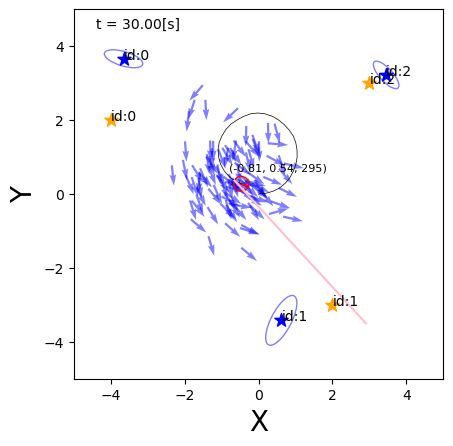

In [38]:
trial()